# Predicting Bike Rentals

## Intro to the Data

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

 * instant - A unique sequential ID number for each row
 * dteday - The date of the rentals
 * season - The season in which the rentals occurred
 * yr - The year the rentals occurred
 * mnth - The month the rentals occurred
 * hr - The hour the rentals occurred
 * holiday - Whether or not the day was a holiday
 * weekday - The day of the week (as a number, 0 to 7)
 * workingday - Whether or not the day was a working day
 * weathersit - The weather (as a categorical variable)
 * temp - The temperature, on a 0-1 scale
 * atemp - The adjusted temperature
 * hum - The humidity, on a 0-1 scale
 * windspeed - The wind speed, on a 0-1 scale
 * casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
 * registered - The number of registered riders (people who had already signed up)
 * cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. (We'll predict the cnt column using all of the other columns, except for casual and registered.) To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals = pd.read_csv("hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.shape

(17379, 17)

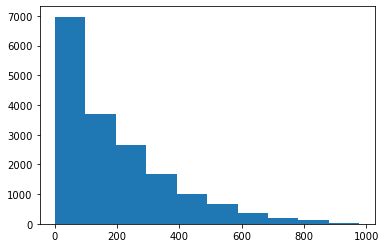

In [3]:
plt.hist(bike_rentals['cnt'])
plt.show()

In [4]:
abs(bike_rentals.corr()['cnt']).sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

## Calculating Features

### Bundling Hours

In [5]:
def assign_label(hr):
    if hr <= 6:
        return 4
    elif 6 < hr <= 12:
        return 1
    elif 12 < hr <= 18:
        return 2
    elif 18 < hr <= 24:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

### Bundling Weather

In [6]:
bike_rentals['weather_index'] = bike_rentals['temp'] + bike_rentals['hum'] + bike_rentals['windspeed']

In [7]:
abs(bike_rentals.corr()['cnt']).sort_values(ascending=False)

cnt              1.000000
registered       0.972151
casual           0.694564
time_label       0.494422
temp             0.404772
atemp            0.400929
hr               0.394071
hum              0.322911
instant          0.278379
yr               0.250495
season           0.178056
weathersit       0.142426
mnth             0.120638
weather_index    0.102756
windspeed        0.093234
holiday          0.030927
workingday       0.030284
weekday          0.026900
Name: cnt, dtype: float64

## Splitting the Data Into Train, Validation and Test Sets

Based on the cnt column, we'll use the MSE (Mean Squared Error) as the error metric for our models.  The MSE works well with continuous numeric data, which is what we're dealing with.

In [8]:
train = bike_rentals.sample(frac=.6, random_state=1)
remainder = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
val = remainder.sample(frac=.5, random_state=1)
test = remainder.loc[~remainder.index.isin(val.index)]

In [9]:
train.shape, val.shape, test.shape

((10427, 19), (3476, 19), (3476, 19))

## Linear Regression

In [10]:
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'time_label']
target = ['cnt']

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[features], train['cnt'])
val_predictions = lr.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = lr.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 16598.376501726925       val mse: 15795.340172836932       difference: 803.0363288899935


The training and validation MSE's are very close togther.  This suggest our model is not overfitting.  However, this MSE seems very high... probably due to the fact that there are a few very high rental counts and these large errors are penalized more with MSE.

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |

Let's explore other models to see if we can improve.

## Decision Trees

### Default Parameters
We'll begin with default parameters.

In [12]:
from sklearn.tree import DecisionTreeRegressor

dtr1 = DecisionTreeRegressor(random_state=1)
dtr1.fit(train[features], train['cnt'])
val_predictions = dtr1.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = dtr1.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 0.1980914932387072       val mse: 3738.3179660529345       difference: 3738.1198745596957


The trian and validation values are no where close to each other, suggesting that our model is overfitting badly.

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |

Let's try to tune some hyperparameters on this model to improve.

### Optimizing max_depth Parameter

In [13]:
val_mses = []
train_mses = []

for i in range(1,30):
    dtr2 = DecisionTreeRegressor(max_depth=i, random_state=1)
    dtr2.fit(train[features], train['cnt'])
    val_predictions = dtr2.predict(val[features])
    val_mse = np.mean((val_predictions - val['cnt']) ** 2)
    val_mses.append(val_mse)
    train_predictions = dtr2.predict(train[features])
    train_mse = np.mean((train_predictions - train['cnt']) ** 2)
    train_mses.append(train_mse)
    difference = abs(val_mse - train_mse)
    print('i:{}  val_mse:{}  train_mse:{}  difference: {}'.format(i, val_mse, train_mse, difference))

i:1  val_mse:22301.318153072145  train_mse:23694.357576165083  difference: 1393.0394230929378
i:2  val_mse:18671.18285930178  train_mse:20024.02986757252  difference: 1352.847008270739
i:3  val_mse:15937.366391751859  train_mse:17130.392322588854  difference: 1193.025930836995
i:4  val_mse:13484.148565173959  train_mse:14481.579980796783  difference: 997.4314156228247
i:5  val_mse:11469.897211128733  train_mse:11664.903448889168  difference: 195.0062377604354
i:6  val_mse:10134.982754975676  train_mse:10134.589868852496  difference: 0.3928861231797782
i:7  val_mse:6973.134306034776  train_mse:6736.0652403292215  difference: 237.06906570555475
i:8  val_mse:5444.157904900875  train_mse:4623.748470665714  difference: 820.4094342351609
i:9  val_mse:4225.240938331656  train_mse:3223.1977471725972  difference: 1002.043191159059
i:10  val_mse:3944.8009849816654  train_mse:2326.4969978890495  difference: 1618.303987092616
i:11  val_mse:3597.140986034394  train_mse:1704.6654585233398  differenc

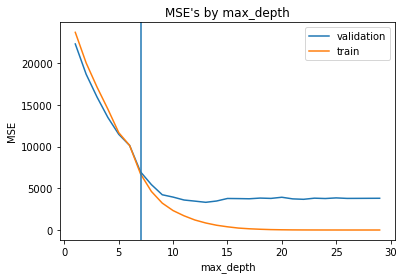

In [14]:
x = range(1,30)
plt.plot(x,val_mses,label="validation")
plt.plot(x,train_mses, label="train")
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title("MSE's by max_depth")
plt.axvline(7)
plt.legend()
plt.show()

As we can see the validation min occurs at a max_depth value of 14.  But if we choose a value of 7, w minimize the difference between the train and validation MSE's which will help us prevent overfitting.

In [15]:
dtr2 = DecisionTreeRegressor(max_depth=7, random_state=1)
dtr2.fit(train[features], train['cnt'])
val_predictions = dtr2.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = dtr2.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 6736.0652403292215       val mse: 6973.134306034776       difference: 237.06906570555475


From these results, we have greatly improved on our model, and don't appear to be overfitting.

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |

Let's try optimizing our min_samples_leaf parameter next.

### Optimizing min_samples_leaf Parameter

In [16]:
val_mses = []
train_mses = []

for i in range(1,20):
    dtr3 = DecisionTreeRegressor(max_depth=7, min_samples_leaf=i, random_state=1)
    dtr3.fit(train[features], train['cnt'])
    val_predictions = dtr3.predict(val[features])
    val_mse = np.mean((val_predictions - val['cnt']) ** 2)
    val_mses.append(val_mse)
    train_predictions = dtr3.predict(train[features])
    train_mse = np.mean((train_predictions - train['cnt']) ** 2)
    train_mses.append(train_mse)
    difference = abs(val_mse - train_mse)
    print('i:{}  val_mse:{}  train_mse:{}  difference: {}'.format(i, val_mse, train_mse, difference))

i:1  val_mse:6973.134306034776  train_mse:6736.0652403292215  difference: 237.06906570555475
i:2  val_mse:6970.562694730837  train_mse:6739.125951552301  difference: 231.43674317853674
i:3  val_mse:6970.438559315751  train_mse:6739.260597285322  difference: 231.17796203042963
i:4  val_mse:6971.211133544921  train_mse:6740.899885265721  difference: 230.3112482791994
i:5  val_mse:6971.611526841898  train_mse:6741.032114821274  difference: 230.57941202062375
i:6  val_mse:6971.042197862008  train_mse:6742.3587808349  difference: 228.68341702710768
i:7  val_mse:6967.119808047431  train_mse:6743.481242667049  difference: 223.63856538038272
i:8  val_mse:6972.342349096207  train_mse:6747.586541935654  difference: 224.75580716055265
i:9  val_mse:6974.086736334363  train_mse:6748.309057016863  difference: 225.77767931749986
i:10  val_mse:6974.264510250231  train_mse:6748.446785856521  difference: 225.8177243937098
i:11  val_mse:6970.928263502918  train_mse:6749.639930750035  difference: 221.2883

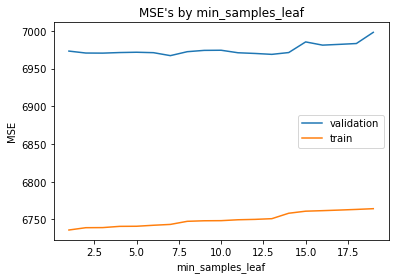

In [17]:
x = range(1,20)
plt.plot(x,val_mses,label="validation")
plt.plot(x,train_mses, label="train")
plt.xlabel('min_samples_leaf')
plt.ylabel('MSE')
plt.title("MSE's by min_samples_leaf")
plt.legend()
plt.show()

From this graph we can see that choosing a min_samples_leaf value of 7 minimizes our validation MSE and also slightly lowers the difference between validation MSE and train MSE so this is a slight improvement on our model.

In [18]:
dtr3 = DecisionTreeRegressor(max_depth=7, min_samples_leaf=7, random_state=1)
dtr3.fit(train[features], train['cnt'])
val_predictions = dtr3.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = dtr3.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 6743.481242667049       val mse: 6967.119808047431       difference: 223.63856538038272


Results below:

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 223.63 |

Let's continue to look if we can improve with a random forest model.

## Random Forests

### Default Parameters
Again, we'll begin with default parameters.

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(random_state=1)
rf1.fit(train[features], train['cnt'])
val_predictions = rf1.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf1.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 270.8788545594664       val mse: 2056.17433461927       difference: 1785.2954800598038


We can see again, that the default parameters produce a model that is badly overfitting.

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 223.63 |
| Random Forest - default params | 270.87 | 2,056.17 | 1,785.29 |

Let's see if we can correct that with some tuning.

### Optimizing the max_depth Parameter

In [20]:
val_mses = []
train_mses = []

for i in range(1,20):
    rf2 = RandomForestRegressor(max_depth=i, random_state=1)
    rf2.fit(train[features], train['cnt'])
    val_predictions = rf2.predict(val[features])
    val_mse = np.mean((val_predictions - val['cnt']) ** 2)
    val_mses.append(val_mse)
    train_predictions = rf2.predict(train[features])
    train_mse = np.mean((train_predictions - train['cnt']) ** 2)
    train_mses.append(train_mse)
    diff = val_mse - train_mse
    percent_diff = round((diff/val_mse),2)
    print('i:{} val_mse:{} train_mse:{} diff:{} %:{}'.format(i, val_mse, train_mse, diff, percent_diff))

i:1 val_mse:22303.173995862846 train_mse:23694.392069059297 diff:-1391.2180731964509 %:-0.06
i:2 val_mse:18504.478336960663 train_mse:19853.945975213675 diff:-1349.4676382530124 %:-0.07
i:3 val_mse:15606.003900141819 train_mse:16801.68915447394 diff:-1195.685254332122 %:-0.08
i:4 val_mse:13099.937893938797 train_mse:14080.885708351178 diff:-980.9478144123805 %:-0.07
i:5 val_mse:10980.09551726562 train_mse:11260.744127632264 diff:-280.6486103666448 %:-0.03
i:6 val_mse:9186.069379079441 train_mse:9295.497663399374 diff:-109.42828431993257 %:-0.01
i:7 val_mse:5821.785623242702 train_mse:5659.462139501373 diff:162.32348374132926 %:0.03
i:8 val_mse:4374.760298124888 train_mse:3841.1299569166463 diff:533.630341208242 %:0.12
i:9 val_mse:3339.0401473737347 train_mse:2611.7394872070004 diff:727.3006601667344 %:0.22
i:10 val_mse:2797.1996777421555 train_mse:1817.1741284207378 diff:980.0255493214177 %:0.35
i:11 val_mse:2466.4861172351266 train_mse:1286.8306279223775 diff:1179.655489312749 %:0.48


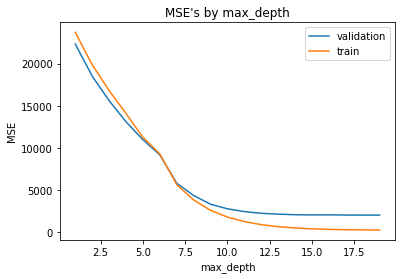

In [21]:
x = range(1,20)
plt.plot(x,val_mses,label="validation")
plt.plot(x,train_mses, label="train")
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title("MSE's by max_depth")
plt.legend()
plt.show()

Based on these results, it appears a max_depth of 7 is appropriate.

In [22]:
rf2 = RandomForestRegressor(max_depth=7, random_state=1)
rf2.fit(train[features], train['cnt'])
val_predictions = rf2.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf2.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 5659.462139501373       val mse: 5821.785623242702       difference: 162.32348374132926


This model (with max_depth=7) is an improvement and our best model yet, as it both lowers MSE values and helps to correct our overfitting.

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 223.63 |
| Random Forest - default params | 270.87 | 2,056.17 | 1,785.29 |
| Random Forest - max_depth=7 | 5,659.46 | 5821.78 | 162.32 |

Let's see if we can improve more by tuning other parameters.

### Optimizing the min_samples_leaf Parameter

In [23]:
val_mses = []
train_mses = []

for i in range(1,20):
    rf3 = RandomForestRegressor(max_depth=7, min_samples_leaf=i, random_state=1)
    rf3.fit(train[features], train['cnt'])
    val_predictions = rf3.predict(val[features])
    val_mse = np.mean((val_predictions - val['cnt']) ** 2)
    val_mses.append(val_mse)
    train_predictions = rf3.predict(train[features])
    train_mse = np.mean((train_predictions - train['cnt']) ** 2)
    train_mses.append(train_mse)
    diff = val_mse - train_mse
    percent_diff = round((diff/val_mse),2)
    print('i:{}  val_mse:{}  train_mse:{}  diff:{}  %:{}'.format(i, val_mse, train_mse, diff, percent_diff))

i:1  val_mse:5821.785623242702  train_mse:5659.462139501373  diff:162.32348374132926  %:0.03
i:2  val_mse:5811.731832742187  train_mse:5661.811152224412  diff:149.9206805177755  %:0.03
i:3  val_mse:5812.925679205616  train_mse:5663.814921767265  diff:149.11075743835045  %:0.03
i:4  val_mse:5813.397390221858  train_mse:5664.733360329468  diff:148.6640298923894  %:0.03
i:5  val_mse:5812.028611179545  train_mse:5666.685189658643  diff:145.34342152090176  %:0.03
i:6  val_mse:5813.2224734054325  train_mse:5668.24371819849  diff:144.97875520694288  %:0.02
i:7  val_mse:5813.467962702556  train_mse:5670.530341534822  diff:142.9376211677345  %:0.02
i:8  val_mse:5813.071964036915  train_mse:5672.796619161845  diff:140.27534487507  %:0.02
i:9  val_mse:5812.9747600028595  train_mse:5676.361134013551  diff:136.61362598930828  %:0.02
i:10  val_mse:5813.021583061744  train_mse:5680.800883956488  diff:132.22069910525624  %:0.02
i:11  val_mse:5815.4288034088595  train_mse:5684.285981925644  diff:131.14

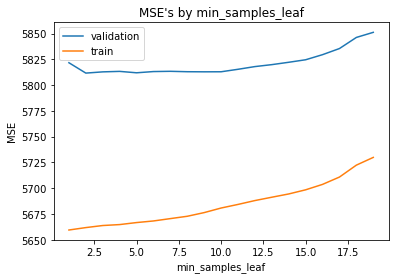

In [24]:
x = range(1,20)
plt.plot(x,val_mses,label="validation")
plt.plot(x,train_mses, label="train")
plt.xlabel('min_samples_leaf')
plt.ylabel('MSE')
plt.title("MSE's by min_samples_leaf")
plt.legend()
plt.show()

Choosing a min_samples_leaf value of 10 helps to minimize the difference between the MSE's and still keep the overall MSE's low.

In [25]:
rf3 = RandomForestRegressor(max_depth=7, min_samples_leaf=10, random_state=1)
rf3.fit(train[features], train['cnt'])
val_predictions = rf3.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf3.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 5680.800883956488       val mse: 5813.021583061744       difference: 132.22069910525624


There is now no sign of overfitting, and we've kept our MSE values low:

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 223.63 |
| Random Forest - default params | 270.87 | 2,056.17 | 1,785.29 |
| Random Forest - max_depth=7 | 5,659.46 | 5821.78 | 162.32 |
| Random Forest - max_depth=7, min_samples_leaf=10 | 5,680.80 | 5,813.02 | 132.22 |

Let's try optimizing one more parameter before we conclude.

### Optimizing n_estimators Parameter

In [26]:
val_mses = []
train_mses = []

for i in range(40,81,1):
    rf4 = RandomForestRegressor(min_samples_leaf=10, max_depth=7, n_estimators=i, random_state=1)
    rf4.fit(train[features], train['cnt'])
    val_predictions = rf4.predict(val[features])
    val_mse = np.mean((val_predictions - val['cnt']) ** 2)
    val_mses.append(val_mse)
    train_predictions = rf4.predict(train[features])
    train_mse = np.mean((train_predictions - train['cnt']) ** 2)
    train_mses.append(train_mse)
    diff = val_mse - train_mse
    percent_diff = round((diff/val_mse),2)
    print('i:{}  val_mse:{}  train_mse:{}  diff:{}  %:{}'.format(i, val_mse, train_mse, diff, percent_diff))

i:40  val_mse:5856.902677965206  train_mse:5713.636373304555  diff:143.26630466065126  %:0.02
i:41  val_mse:5840.280011084992  train_mse:5696.621653080826  diff:143.65835800416608  %:0.02
i:42  val_mse:5830.411890156162  train_mse:5684.559611848408  diff:145.8522783077542  %:0.03
i:43  val_mse:5831.8763702343  train_mse:5685.457799880899  diff:146.41857035340126  %:0.03
i:44  val_mse:5841.033545908452  train_mse:5693.993625563545  diff:147.03992034490693  %:0.03
i:45  val_mse:5845.655179656639  train_mse:5694.093087955696  diff:151.5620917009428  %:0.03
i:46  val_mse:5838.568443222037  train_mse:5685.303111565028  diff:153.26533165700857  %:0.03
i:47  val_mse:5830.010898031603  train_mse:5676.221990896889  diff:153.78890713471355  %:0.03
i:48  val_mse:5828.335020271083  train_mse:5678.8049156097895  diff:149.53010466129308  %:0.03
i:49  val_mse:5825.606783248186  train_mse:5678.6098933319945  diff:146.99688991619132  %:0.03
i:50  val_mse:5817.376423905122  train_mse:5672.564859005813  

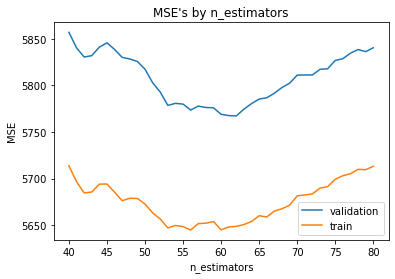

In [27]:
x = range(40,81,1)
plt.plot(x,val_mses,label="validation")
plt.plot(x,train_mses, label="train")
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title("MSE's by n_estimators")
plt.legend()
plt.show()

For our purposes, we'll choose the value of 62 as it minimizes the validation MSE and the difference between train and validation MSE values.

In [28]:
rf4 = RandomForestRegressor(min_samples_leaf=10, max_depth=7, n_estimators=62, random_state=1)
rf4.fit(train[features], train['cnt'])
val_predictions = rf4.predict(val[features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf4.predict(train[features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 5648.629554456764       val mse: 5767.1679033278215       difference: 118.53834887105768


Now to compare our values:

| Model | Train MSE | Validation MSE | Difference |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,795.34 | 803.03 |
| Decision Tree Regressor - default params | 0.19 | 3,738.31 | 3,738.11 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,973.13 | 237.06 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 223.63 |
| Random Forest - default params | 270.87 | 2,056.17 | 1,785.29 |
| Random Forest - max_depth=7 | 5,659.46 | 5821.78 | 162.32 |
| Random Forest - max_depth=7, min_samples_leaf=10 | 5,680.80 | 5,813.02 | 132.22 |
| Random Forest - max_depth=7, min_samples_leaf=10, n_estimators=62 | 5,648.62 | 5,767.16 | 118.53 |

This yields a slight improvement to our model and this is our best model yet.

Let's see how the models perform on new data.

## Making Predictions

### Linear Regression Model

In [29]:
test_predictions = lr.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 15477.810680082677


### Decision Tree Models

#### Default Params

In [30]:
test_predictions = dtr1.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 3553.0707710011507


#### max_depth=7

In [31]:
test_predictions = dtr2.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 6955.9343757873885


#### max_depth=7, min_samples_leaf=14

In [32]:
test_predictions = dtr3.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 6936.317181328416


### Random Forest Models

#### Default Params

In [33]:
test_predictions = rf1.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 1887.4690063131472


#### max_depth=7

In [34]:
test_predictions = rf2.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 5909.90887133457


#### max_depth=7, min_samples_leaf=10

In [35]:
test_predictions = rf3.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 5911.413048541452


#### max_depth=7, min_samples_leaf=10, n_estimators=62

In [36]:
test_predictions = rf4.predict(test[features])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 5876.585696137496


### Testing Results

| Model | Train MSE | Validation MSE | TEST MSE |
| :------- | ------: | ------: | -----: |
| Linear Regressor - default params | 16,598.37 | 15,575.51 | 15,477.81 |
| Decision Tree Regressor - default params \* | 0.19 | 3,640.70 | 3,553.07 |
| Decision Tree Regressor - max_depth=7 | 6,736.06 | 6,701.03 | 6,955.93 |
| Decision Tree Regressor - max_depth=7, min_samples_leaf=7 | 6,743.48 | 6,967.11 | 6,936.31 |
| Random Forest - default params \* | 270.87 | 2,065.64 | 1,887.46 |
| Random Forest - max_depth=7 | 5,659.46 | 5,678.02 | 5,909.90 |
| Random Forest - max_depth=7, min_samples_leaf=10 | 5,680.80 | 5,681.15 | 5,911.41 |
| **Random Forest - max_depth=7, min_samples_leaf=10, n_estimators=60** | **5,644.92** | **5,640.92** | **5,876.58** |
| | | | |
| \* clearly overfitting | | | |

Let's plot a sample of our best model's predictions versus the actual values.

<ipython-input-37-984272f8400b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = test_predictions


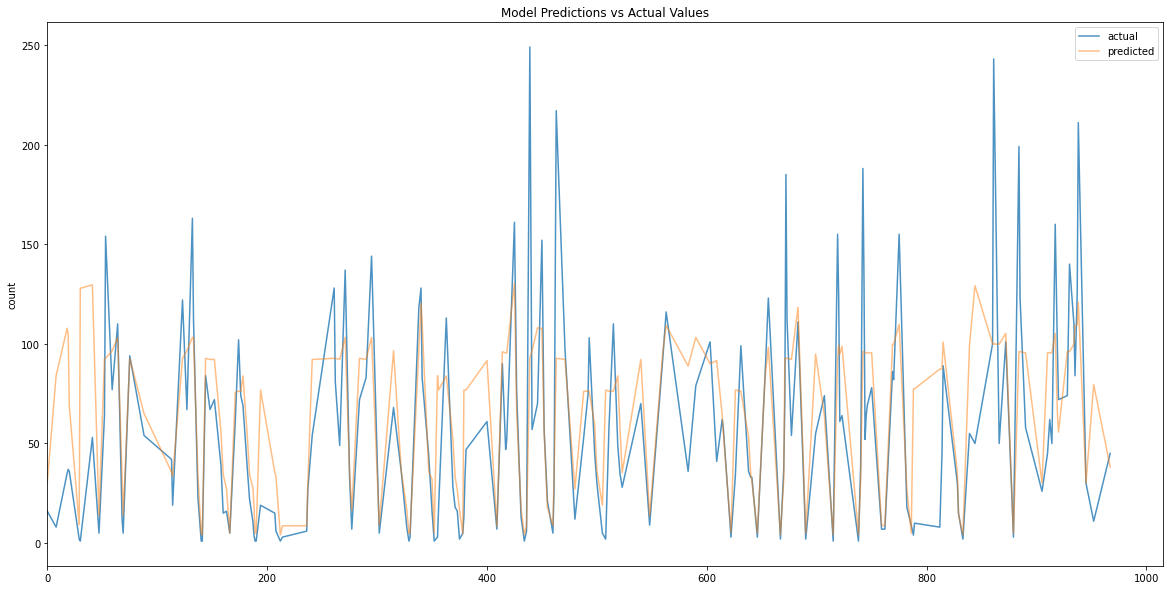

In [37]:
test['predictions'] = test_predictions
x = test.index
fig = plt.figure(figsize = (20,10))
plt.plot(x[:200], test['cnt'][:200], label='actual', alpha=.8)
plt.plot(x[:200], test['predictions'][:200], label='predicted', alpha=.5)
plt.xlim(0, )
plt.ylabel('count')
plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.show()

From this graph, it looks like our model is working pretty well.  It's failing to predict the highest count values which are the right skewed values in the histogram we plotted at the beginning of our project.

## Conclusions

It's clear our Random Forest Regressor with max_depth=7, min_samples_leaf=10, n_estimators=60 is our best model.

### Possible Improvements

  * engineer a weather index feature
  * try removing some of the least correlated features
  * try modeling for 'registered' and 'casual' instead of 'cnt'

## Revisiting Features

### Removing Less Correlated Features

Let's try removing some of the least correlated features to see if this helps our models.

In [38]:
abs(bike_rentals.corr()['cnt']).sort_values(ascending=False)

cnt              1.000000
registered       0.972151
casual           0.694564
time_label       0.494422
temp             0.404772
atemp            0.400929
hr               0.394071
hum              0.322911
instant          0.278379
yr               0.250495
season           0.178056
weathersit       0.142426
mnth             0.120638
weather_index    0.102756
windspeed        0.093234
holiday          0.030927
workingday       0.030284
weekday          0.026900
Name: cnt, dtype: float64

In [39]:
# remove features with correlation < .05
less_features = ['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'hum', 'windspeed', 'time_label']

In [40]:
rf4 = RandomForestRegressor(min_samples_leaf=10, max_depth=7, n_estimators=62, random_state=1)
rf4.fit(train[less_features], train['cnt'])
val_predictions = rf4.predict(val[less_features])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf4.predict(train[less_features])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 8502.699815454234       val mse: 8776.518007247138       difference: 273.81819179290324


It seems removing these features had a significant, negative impact on our model.

Let's see what impact engineering a weather index will have.

### Adding Weather Index Feature

In [41]:
features_plus_weather = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'time_label', 'weather_index']

In [42]:
rf4 = RandomForestRegressor(min_samples_leaf=10, max_depth=7, n_estimators=62, random_state=1)
rf4.fit(train[features_plus_weather], train['cnt'])
val_predictions = rf4.predict(val[features_plus_weather])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf4.predict(train[features_plus_weather])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 5646.270206205294       val mse: 5764.959163539579       difference: 118.68895733428508


In [43]:
test_predictions = rf4.predict(test[features_plus_weather])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 5877.706976888732


These results show no real improvements from our model with original features.

### Removing 'hr' from Features

Since we created a time label, the 'hr' feature is redundant.  Let's see how removing this feature impacts our model.

In [44]:
features_minus_hr = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'time_label']

In [45]:
rf4 = RandomForestRegressor(min_samples_leaf=10, max_depth=7, n_estimators=62, random_state=1)
rf4.fit(train[features_minus_hr], train['cnt'])
val_predictions = rf4.predict(val[features_minus_hr])
val_mse = np.mean((val_predictions - val['cnt']) ** 2)
train_predictions = rf4.predict(train[features_minus_hr])
train_mse = np.mean((train_predictions - train['cnt']) ** 2)
difference = abs(val_mse-train_mse)
print('train mse: {}       val mse: {}       difference: {}'.format(train_mse, val_mse, difference))

train mse: 11839.215241036052       val mse: 11855.720526245888       difference: 16.505285209836075


In [46]:
test_predictions = rf4.predict(test[features_minus_hr])
test_mse = np.mean((test_predictions - test['cnt']) ** 2)
print('test mse: {}'.format(test_mse))

test mse: 11747.175685482813


These results obviously don't enhance our model.  It seems our initial choice for features was best.